In [1]:
# Load the data
import pandas as pd
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

In [2]:
# Get all of the unique labels for train / test sets 
train_labels = list(train_df['room'].unique())
test_labels = list(test_df['room'].unique())

# Labels that appear in BOTH train and test
common_labels = list(set(train_labels) & set(test_labels))

# Now filter the train_df and test_df so that
# remove all record in train_df whose labels not in test labels 
# and remove all record in test_df whose labels not in train labels 
# therefore we can have a proper train and test df such that the labels appear 
# in train and test should be the same and vice versa
train_df = train_df[train_df['room'].isin(common_labels)].reset_index(drop=True)
test_df  = test_df[test_df['room'].isin(common_labels)].reset_index(drop=True)

In [3]:
# CELL 1: Create room groups for sequences
import pandas as pd
import numpy as np

def create_room_groups(df):
    """
    Create room_group column to identify consecutive room visits.
    Each time room changes, we start a new group.
    """
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['room_group'] = (df['room'] != df['room'].shift()).cumsum()
    return df

# Apply to both train and test
train_df = create_room_groups(train_df)
test_df = create_room_groups(test_df)

In [4]:
# CELL 2: Create 23-dimensional beacon count vectors
def create_beacon_count_vectors(df):
    """
    For each window, create a 23-dim vector where each value is the 
    percentage of times that beacon appeared (ignore beacons 24, 25)
    """
    vectors = []
    
    for _, group in df.groupby('timestamp'):
        # Count how many times each beacon appears in this window
        beacon_counts = group['mac address'].value_counts()
        total_readings = len(group)
        
        # Create 23-dim vector (beacons 1-23)
        vector = [0.0] * 23
        for beacon_id, count in beacon_counts.items():
            if 1 <= beacon_id <= 23:  # Only beacons 1-23
                vector[beacon_id - 1] = count / total_readings
        
        vectors.append({
            'timestamp': group['timestamp'].iloc[0],
            'room': group['room'].iloc[0],
            'room_group': group['room_group'].iloc[0],
            'beacon_vector': vector
        })
    
    return pd.DataFrame(vectors)

# Create vectors for train and test
print("Creating beacon vectors for train set...")
train_vectors = create_beacon_count_vectors(train_df)
print(f"✓ Train vectors created: {len(train_vectors)} windows")

print("\nCreating beacon vectors for test set...")
test_vectors = create_beacon_count_vectors(test_df)
print(f"✓ Test vectors created: {len(test_vectors)} windows")

# Show example
print("\nExample beacon vector:")
print(f"Timestamp: {train_vectors.iloc[0]['timestamp']}")
print(f"Room: {train_vectors.iloc[0]['room']}")
print(f"Vector: {train_vectors.iloc[0]['beacon_vector'][:5]}... (showing first 5 beacons)")

Creating beacon vectors for train set...
✓ Train vectors created: 15052 windows

Creating beacon vectors for test set...
✓ Test vectors created: 5889 windows

Example beacon vector:
Timestamp: 2023-04-10 14:21:46+09:00
Room: kitchen
Vector: [0.0, 0.0, 0.0, 0.6936936936936937, 0.0]... (showing first 5 beacons)


In [5]:
# CELL 3: Create sequences grouped by room_group - WITH FRAME TRACKING
def create_sequences_from_groups(vector_df, min_length=3, max_length=50):
    """
    Group consecutive windows into sequences based on room_group.
    Filter out sequences that are too short or too long.
    NOW ALSO RETURNS: frame_indices to track which frames belong to each sequence
    """
    sequences = []
    labels = []
    frame_indices = []  # NEW: Track which frames belong to each sequence
    
    for (room, room_group), group in vector_df.groupby(['room', 'room_group']):
        group = group.sort_values('timestamp').reset_index(drop=False)  # Keep original indices
        seq_length = len(group)
        
        # Filter by length
        if seq_length < min_length:
            continue  # Too short, skip
        
        if seq_length > max_length:
            # Too long, truncate to last max_length windows
            group = group.tail(max_length)
            seq_length = max_length
        
        # Extract beacon vectors as sequence
        sequence = [row['beacon_vector'] for _, row in group.iterrows()]
        
        # NEW: Store the indices of frames in this sequence
        indices = group['index'].tolist()
        
        sequences.append(sequence)
        labels.append(room)
        frame_indices.append(indices)  # NEW
    
    return sequences, labels, frame_indices  # Return frame_indices too

# Create sequences with frame tracking
print("Creating sequences from room groups...")
X_train, y_train, train_frame_indices = create_sequences_from_groups(train_vectors)
X_test, y_test, test_frame_indices = create_sequences_from_groups(test_vectors)

print(f"\n✓ Train sequences: {len(X_train)}")
print(f"✓ Test sequences: {len(X_test)}")

# Show lengths
train_lengths = [len(seq) for seq in X_train]
test_lengths = [len(seq) for seq in X_test]
print(f"\nTrain sequence lengths:")
print(f"  Min: {min(train_lengths)}, Max: {max(train_lengths)}, Mean: {np.mean(train_lengths):.1f}")
print(f"\nTest sequence lengths:")
print(f"  Min: {min(test_lengths)}, Max: {max(test_lengths)}, Mean: {np.mean(test_lengths):.1f}")

# Show label distributions
print(f"\nTrain label distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest label distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Creating sequences from room groups...

✓ Train sequences: 166
✓ Test sequences: 83

Train sequence lengths:
  Min: 3, Max: 50, Mean: 28.1

Test sequence lengths:
  Min: 3, Max: 50, Mean: 30.9

Train label distribution:
501               1
502               1
506               1
511               3
512               1
513               1
517               1
518               1
520               3
522               4
523               8
cafeteria        44
cleaning         10
hallway          21
kitchen          28
nurse station    38
Name: count, dtype: int64

Test label distribution:
501               1
502               3
506               2
511               1
512               2
513               1
518               1
520               2
522               1
523               6
cafeteria        21
cleaning          8
hallway           3
kitchen          10
nurse station    21
Name: count, dtype: int64


In [6]:
# CELL 4: Encode labels and pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test)  # Fit on all labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

# Pad sequences
max_seq_length = 50  # Same as in create_sequences_from_groups
X_train_padded = pad_sequences(X_train, maxlen=max_seq_length, dtype='float32', padding='pre', value=0.0)
X_test_padded = pad_sequences(X_test, maxlen=max_seq_length, dtype='float32', padding='pre', value=0.0)

print(f"\nTrain data shape: {X_train_padded.shape}")
print(f"Test data shape: {X_test_padded.shape}")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Number of classes: 16
Classes: ['501' '502' '506' '511' '512' '513' '517' '518' '520' '522' '523'
 'cafeteria' 'cleaning' 'hallway' 'kitchen' 'nurse station']

Train data shape: (166, 50, 23)
Test data shape: (83, 50, 23)


In [7]:
# CELL 5: Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:")
for class_idx, weight in class_weight_dict.items():
    print(f"  {label_encoder.classes_[class_idx]}: {weight:.2f}")

Class weights:
  501: 10.38
  502: 10.38
  506: 10.38
  511: 3.46
  512: 10.38
  513: 10.38
  517: 10.38
  518: 10.38
  520: 3.46
  522: 2.59
  523: 1.30
  cafeteria: 0.24
  cleaning: 1.04
  hallway: 0.49
  kitchen: 0.37
  nurse station: 0.27


In [8]:
# CELL 6: Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_lstm_model(
    input_shape=(max_seq_length, 23),
    num_classes=len(label_encoder.classes_)
)

model.summary()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,840 (507.19 KB)

 Trainable params: 129,840 (507.19 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# CELL 7: Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

In [10]:
# CELL 8: Train the model
history = model.fit(
    X_train_padded, y_train_encoded,
    validation_data=(X_test_padded, y_test_encoded),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.1506 - loss: 2.7818 - val_accuracy: 0.1566 - val_loss: 2.7462 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2169 - loss: 2.7410 - val_accuracy: 0.3133 - val_loss: 2.7066 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3012 - loss: 2.7107 - val_accuracy: 0.3012 - val_loss: 2.6402 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2470 - loss: 2.6326 - val_accuracy: 0.2410 - val_loss: 2.4527 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2108 - loss: 2.5757 - val_accuracy: 0.2410 - val_loss: 2.3061 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2530 - loss: 2.4987 - val_accuracy: 0.2892 - val_loss: 2.0780 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3614 - loss: 2.3662 - val_accuracy:

In [11]:
# CELL 9: Get sequence-level predictions
y_pred_probs = model.predict(X_test_padded)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Sequence-level metrics
from sklearn.metrics import classification_report, f1_score

print("="*60)
print("SEQUENCE-LEVEL EVALUATION")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

macro_f1_sequence = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"\n✓ Sequence-level Macro F1 Score: {macro_f1_sequence:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
SEQUENCE-LEVEL EVALUATION

Classification Report:
               precision    recall  f1-score   support

          501       0.00      0.00      0.00         1
          502       1.00      0.33      0.50         3
          506       0.50      0.50      0.50         2
          511       1.00      1.00      1.00         1
          512       1.00      0.50      0.67         2
          513       0.00      0.00      0.00         1
          517       0.00      0.00      0.00         0
          518       0.00      0.00      0.00         1
          520       1.00      0.50      0.67         2
          522       1.00      1.00      1.00         1
          523       0.75      1.00      0.86         6
    cafeteria       0.60      0.29      0.39        21
     cleaning       0.75      0.75      0.75         8
      hallway       0.00      0.00      0.00         3
      kitchen       0.53      1.00      0.69        10
nurse station       0.65      

In [12]:
# CELL 10: PROPAGATE PREDICTIONS TO FRAME LEVEL
print("\n" + "="*60)
print("PROPAGATING PREDICTIONS TO FRAME LEVEL")
print("="*60)

# Create a copy of test_vectors to add predictions
test_vectors_with_predictions = test_vectors.copy()

# Initialize prediction column with None
test_vectors_with_predictions['predicted_room'] = None

# Propagate each sequence prediction to its constituent frames
for seq_idx, (pred_label, frame_idx_list) in enumerate(zip(y_pred, test_frame_indices)):
    # Assign the sequence prediction to all frames in this sequence
    for frame_idx in frame_idx_list:
        test_vectors_with_predictions.loc[frame_idx, 'predicted_room'] = pred_label

# Filter out frames that weren't part of any sequence (too short sequences)
test_vectors_with_predictions = test_vectors_with_predictions[test_vectors_with_predictions['predicted_room'].notna()]

print(f"\n✓ Propagated predictions to {len(test_vectors_with_predictions)} frames")
print(f"  (out of {len(test_vectors)} total test frames)")

# Show example
print("\nExample frame-level predictions:")
print(test_vectors_with_predictions[['timestamp', 'room', 'predicted_room']].head(10))


PROPAGATING PREDICTIONS TO FRAME LEVEL

✓ Propagated predictions to 2565 frames
  (out of 5889 total test frames)

Example frame-level predictions:
                     timestamp       room predicted_room
232  2023-04-12 10:05:04+09:00  cafeteria        kitchen
233  2023-04-12 10:05:05+09:00  cafeteria        kitchen
234  2023-04-12 10:05:06+09:00  cafeteria        kitchen
235  2023-04-12 10:05:07+09:00  cafeteria        kitchen
236  2023-04-12 10:05:08+09:00  cafeteria        kitchen
237  2023-04-12 10:05:09+09:00  cafeteria        kitchen
238  2023-04-12 10:05:10+09:00  cafeteria        kitchen
239  2023-04-12 10:05:11+09:00  cafeteria        kitchen
240  2023-04-12 10:05:12+09:00  cafeteria        kitchen
241  2023-04-12 10:05:13+09:00  cafeteria        kitchen


In [13]:
# CELL 11: CALCULATE FRAME-LEVEL MACRO F1
print("\n" + "="*60)
print("FRAME-LEVEL EVALUATION")
print("="*60)

y_true_frames = test_vectors_with_predictions['room'].values
y_pred_frames = test_vectors_with_predictions['predicted_room'].values

print("\nFrame-level Classification Report:")
print(classification_report(y_true_frames, y_pred_frames, zero_division=0))

macro_f1_frame = f1_score(y_true_frames, y_pred_frames, average='macro', zero_division=0)
print(f"\n✓ Frame-level Macro F1 Score: {macro_f1_frame:.4f}")

# Compare sequence vs frame level
print("\n" + "="*60)
print("COMPARISON: SEQUENCE vs FRAME LEVEL")
print("="*60)
print(f"Sequence-level Macro F1: {macro_f1_sequence:.4f}")
print(f"Frame-level Macro F1:    {macro_f1_frame:.4f}")
print(f"Difference:              {macro_f1_frame - macro_f1_sequence:+.4f}")


FRAME-LEVEL EVALUATION

Frame-level Classification Report:
               precision    recall  f1-score   support

          501       0.00      0.00      0.00        15
          502       1.00      0.25      0.40        69
          506       0.50      0.75      0.60        67
          511       1.00      1.00      1.00        46
          512       1.00      0.50      0.67       100
          513       0.00      0.00      0.00        50
          517       0.00      0.00      0.00         0
          518       0.00      0.00      0.00        13
          520       1.00      0.86      0.93        58
          522       1.00      1.00      1.00        17
          523       0.49      1.00      0.65        91
    cafeteria       0.47      0.13      0.21       580
     cleaning       0.83      0.70      0.76       186
      hallway       0.00      0.00      0.00       145
      kitchen       0.58      1.00      0.74       455
nurse station       0.62      0.76      0.69       673

   

In [14]:
# CELL 12: PER-CLASS FRAME-LEVEL ANALYSIS
print("\n" + "="*60)
print("PER-CLASS FRAME-LEVEL F1 SCORES")
print("="*60)

from sklearn.metrics import f1_score

# Calculate F1 for each class
per_class_f1 = f1_score(y_true_frames, y_pred_frames, average=None, zero_division=0)
classes = sorted(test_vectors_with_predictions['room'].unique())

# Create a dataframe for better visualization
class_stats = []
for class_name, f1 in zip(classes, per_class_f1):
    n_frames = (y_true_frames == class_name).sum()
    class_stats.append({
        'Class': class_name,
        'Frame-level F1': f1,
        'Num Frames': n_frames
    })

class_stats_df = pd.DataFrame(class_stats).sort_values('Frame-level F1', ascending=False)
print(class_stats_df.to_string(index=False))

print(f"\n✓ Average (Macro) F1: {per_class_f1.mean():.4f}")


PER-CLASS FRAME-LEVEL F1 SCORES
        Class  Frame-level F1  Num Frames
          511        1.000000          46
          523        1.000000          91
          522        0.925926          17
      hallway        0.760234         145
nurse station        0.735651         673
          512        0.666667         100
    cafeteria        0.654676         580
          506        0.598802          67
          502        0.395349          69
     cleaning        0.206989         186
          501        0.000000          15
          518        0.000000          13
          513        0.000000          50
          520        0.000000          58
      kitchen        0.000000         455

✓ Average (Macro) F1: 0.4769


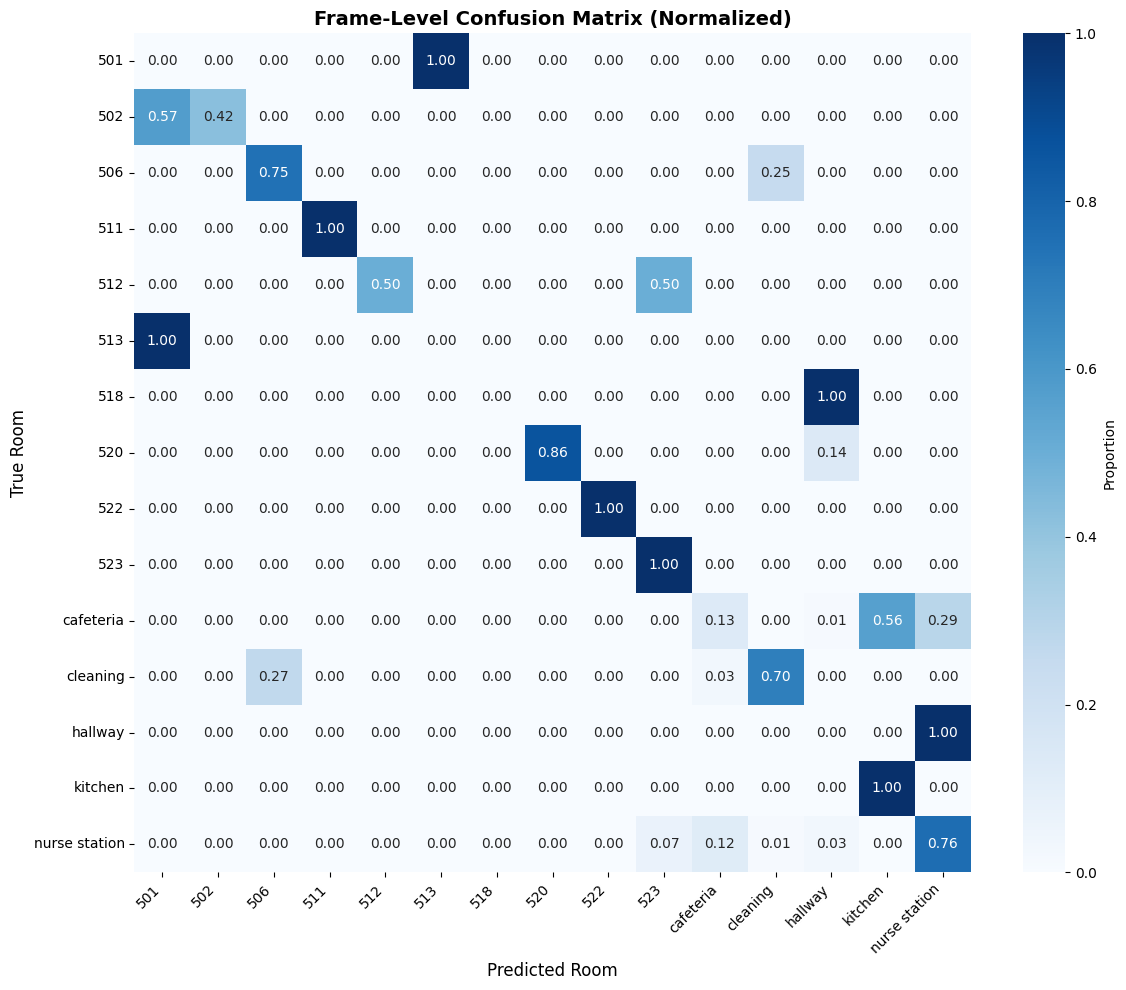


✓ Frame-level confusion matrix generated


In [15]:
# CELL 13: CONFUSION MATRIX - FRAME LEVEL
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_true_frames, y_pred_frames, labels=classes)

# Normalize by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Proportion'})
plt.title('Frame-Level Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Room', fontsize=12)
plt.ylabel('True Room', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n✓ Frame-level confusion matrix generated")

In [16]:
# CELL 14: SAVE FRAME-LEVEL PREDICTIONS
output_file = 'frame_level_predictions.csv'
test_vectors_with_predictions.to_csv(output_file, index=False)
print(f"\n✓ Frame-level predictions saved to: {output_file}")
print(f"  Total frames with predictions: {len(test_vectors_with_predictions)}")


✓ Frame-level predictions saved to: frame_level_predictions.csv
  Total frames with predictions: 2565


## Summary: Frame-Level Prediction Propagation

### What We Did

1. **Modified sequence creation** to track which frames belong to each sequence
2. **Trained LSTM model** on sequence-level predictions (as before)
3. **Propagated predictions** from sequence-level back to individual frames
4. **Calculated frame-level Macro F1** score

### Key Additions

- **Cell 3**: Added `frame_indices` tracking to `create_sequences_from_groups()`
- **Cell 10**: Propagated sequence predictions to all constituent frames
- **Cell 11**: Calculated frame-level Macro F1 score
- **Cell 12**: Per-class frame-level F1 analysis
- **Cell 13**: Frame-level confusion matrix
- **Cell 14**: Save frame-level predictions to CSV

### Understanding the Metrics

**Sequence-level Macro F1**: One prediction per room visit (sequence)
- Example: Kitchen visit with 50 frames = 1 prediction

**Frame-level Macro F1**: One prediction per timestamp window (frame)
- Example: Kitchen visit with 50 frames = 50 predictions (all the same)

The frame-level score will typically be similar to or slightly better than sequence-level because:
- Correct sequence predictions get "amplified" across many frames
- Wrong sequence predictions also get amplified, but less so for shorter sequences
- Reflects the actual deployment scenario where you predict every frame

### Next Steps

For truly continuous frame-by-frame prediction (no ground truth segmentation), implement **Option 3**:
- Sequence-to-sequence LSTM
- Predict each frame independently
- Handle transitions between rooms naturally
